# Day 9
batch size 256 lr 1e-3, normed weighted, non-rotated, cartesian, reflection and rotation augmentation, redux decay

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


## Options

In [2]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [3]:
class RotationReflectionBatch(BatchYielder):
    def __init__(self, header, datafile=None, augRotMult=4, trainTimeAug=True, testTimeAug=True):
        self.header = header
        self.augmented = True
        self.augRotMult = augRotMult
        self.augMult = self.augRotMult*4
        self.trainTimeAug = trainTimeAug
        self.testTimeAug = testTimeAug
        if not isinstance(datafile, types.NoneType):
            self.addSource(datafile)
    
    @staticmethod
    def rotate(inData, vectors):
        for vector in vectors:
            inData.loc[:, vector + '_px'] = inData.loc[:, vector + '_px']*np.cos(inData.loc[:, 'aug_angle'])-inData.loc[:, vector + '_py']*np.sin(inData.loc[:, 'aug_angle'])
            inData.loc[:, vector + '_py'] = inData.loc[:, vector + '_py']*np.cos(inData.loc[:, 'aug_angle'])+inData.loc[:, vector + '_px']*np.sin(inData.loc[:, 'aug_angle'])
    
    @staticmethod
    def reflect(inData, vectors):
        for vector in vectors:
            for coord in ['_px', '_pz']:
                try:
                    inData.loc[inData['aug' + coord] == 1, vector + coord] = -inData.loc[inData['aug' + coord] == 1, vector + coord]
                except KeyError:
                    pass
            
    def getBatch(self, index, datafile=None):
        if isinstance(datafile, types.NoneType):
            datafile = self.source
            
        index = str(index)
        weights = None
        targets = None
        if 'fold_' + index + '/weights' in datafile:
            weights = np.array(datafile['fold_' + index + '/weights'])
        if 'fold_' + index + '/targets' in datafile:
            targets = np.array(datafile['fold_' + index + '/targets'])

        inputs = pandas.DataFrame(np.array(datafile['fold_' + index + '/inputs']), columns=self.header)
        vectors = [x[:-3] for x in inputs.columns if '_px' in x]
        inputs['aug_angle'] = 2*np.pi*np.random.random(size=len(inputs))
        for coord in ['_px', '_pz']:
            inputs['aug' + coord] = np.random.randint(0, 2, size=len(inputs))
        self.rotate(inputs, vectors)
        self.reflect(inputs, vectors)
        
        return {'inputs':inputs[self.header].values,
                'targets':targets,
                'weights':weights}
    
    def getTestBatch(self, index, augIndex, datafile=None):
        if augIndex >= self.augMult:
            print "Invalid augmentation index passed", augIndex
            return -1
        
        if isinstance(datafile, types.NoneType):
            datafile = self.source
            
        index = str(index)
        weights = None
        targets = None
        if 'fold_' + index + '/weights' in datafile:
            weights = np.array(datafile['fold_' + index + '/weights'])
        if 'fold_' + index + '/targets' in datafile:
            targets = np.array(datafile['fold_' + index + '/targets'])
            
        inputs = pandas.DataFrame(np.array(datafile['fold_' + index + '/inputs']), columns=self.header)
        rotIndex = augIndex%self.augRotMult
        refIndex = '{0:02b}'.format(int(augIndex/4))
        vectors = [x[:-3] for x in inputs.columns if '_px' in x]
        inputs['aug_angle'] = np.linspace(0, 2*np.pi, (self.augRotMult)+1)[rotIndex]
        for i, coord in enumerate(['_px', '_pz']):
            inputs['aug' + coord] = int(refIndex[i])
        self.rotate(inputs, vectors)
        self.reflect(inputs, vectors)

        return {'inputs':inputs[self.header].values,
                'targets':targets,
                'weights':weights}

In [4]:
trainData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r+"))
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"))

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.167s 


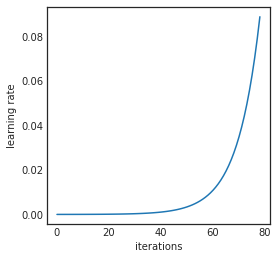

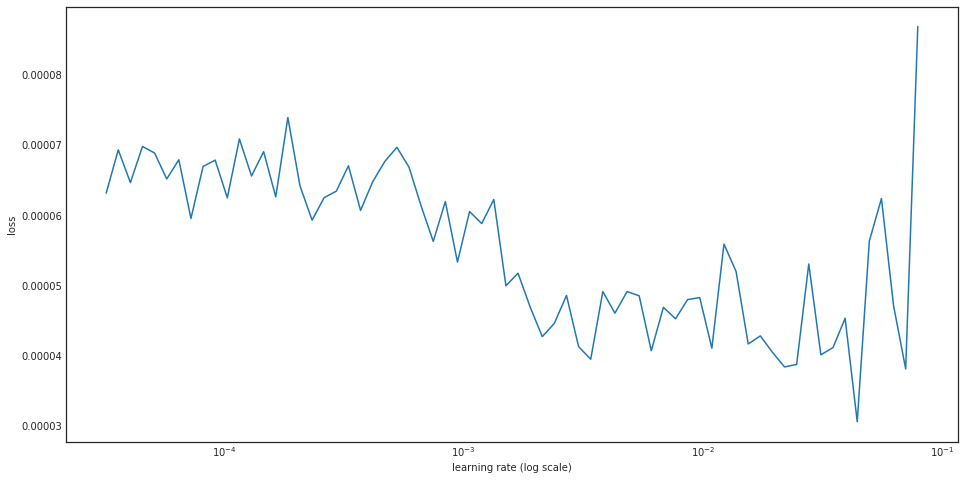

______________________________________



In [5]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,1e-1], trainOnWeights=True, verbose=0)

In [5]:
compileArgs['lr'] = 1e-3

## Train classifier

Using cosine annealing
Training using weights
Running fold 1 / 10
2 classes found, running in binary mode



/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140468). Check your callbacks.
  % delta_t_median)


1 New best found: 4.23521071146e-05
2 New best found: 3.86995275822e-05
3 New best found: 3.78438749787e-05
4 New best found: 3.76491834545e-05
5 New best found: 3.64371159151e-05
6 New best found: 3.58039018641e-05
7 New best found: 3.57029691591e-05
9 New best found: 3.52293018676e-05
10 New best found: 3.503469127e-05
11 New best found: 3.48392587668e-05
12 New best found: 3.47965349134e-05
13 New best found: 3.47109646515e-05
14 New best found: 3.45133548533e-05
15 New best found: 3.44556424952e-05
18 New best found: 3.44055532889e-05
20 New best found: 3.42633415884e-05
21 New best found: 3.42338358997e-05
22 New best found: 3.41181038751e-05
23 New best found: 3.39648116411e-05
24 New best found: 3.35440552085e-05
29 New best found: 3.35231684956e-05
31 New best found: 3.35102866103e-05
39 New best found: 3.35036125724e-05
43 New best found: 3.34706481781e-05
44 New best found: 3.32230010924e-05
45 New best found: 3.30844935012e-05
47 New best found: 3.30182480266e-05
50 New best

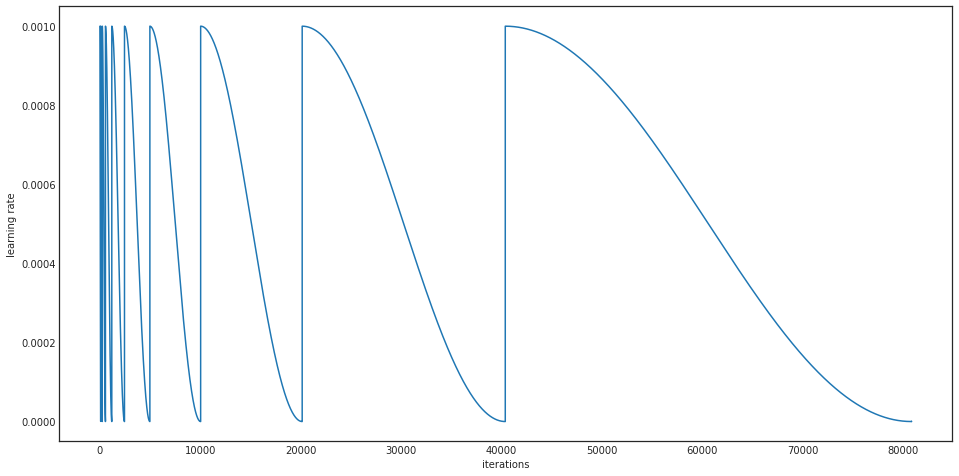

Fold took 1169.621s

Running fold 2 / 10


/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.147637). Check your callbacks.
  % delta_t_median)


1 New best found: 4.46062436086e-05
2 New best found: 3.90192552957e-05
3 New best found: 3.7945050197e-05
4 New best found: 3.6508390385e-05
5 New best found: 3.56424472675e-05
6 New best found: 3.54070354503e-05
7 New best found: 3.52166463603e-05
9 New best found: 3.50928836397e-05
10 New best found: 3.46225067913e-05
11 New best found: 3.43757714363e-05
12 New best found: 3.41381031018e-05
13 New best found: 3.40398511109e-05
14 New best found: 3.39872968213e-05
15 New best found: 3.39486157888e-05
18 New best found: 3.37191669511e-05
22 New best found: 3.35531705568e-05
23 New best found: 3.31214680632e-05
27 New best found: 3.31116142842e-05
29 New best found: 3.310185766e-05
30 New best found: 3.30944431479e-05
31 New best found: 3.30256607018e-05
42 New best found: 3.27736127398e-05
47 New best found: 3.26190418947e-05
49 New best found: 3.25416074116e-05
50 New best found: 3.24778330427e-05
52 New best found: 3.24572488748e-05
54 New best found: 3.22941159714e-05
56 New best f

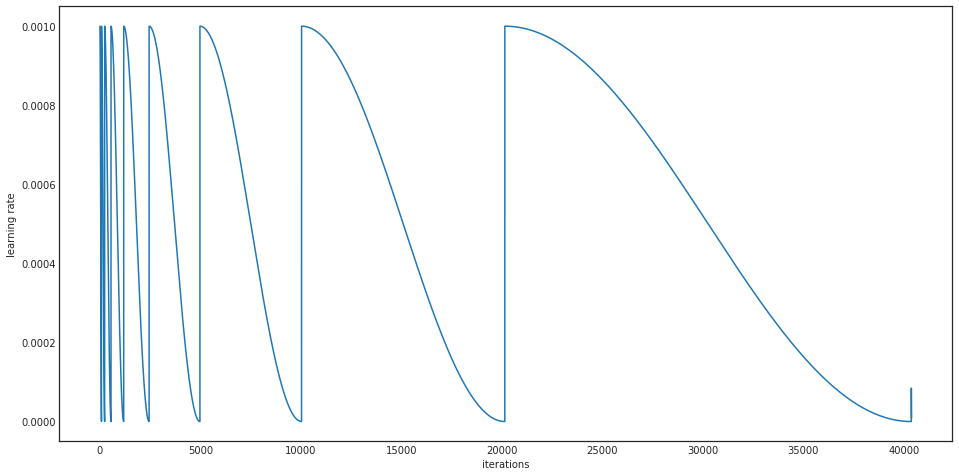

Fold took 593.374s

Running fold 3 / 10


/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.137836). Check your callbacks.
  % delta_t_median)


1 New best found: 4.48909319669e-05
2 New best found: 4.01808787335e-05
3 New best found: 3.93545823221e-05
4 New best found: 3.76020932385e-05
5 New best found: 3.71717850145e-05
6 New best found: 3.64265825006e-05
8 New best found: 3.60828034826e-05
11 New best found: 3.57003205758e-05
12 New best found: 3.53283078476e-05
13 New best found: 3.5065816577e-05
14 New best found: 3.50276246683e-05
15 New best found: 3.49111669353e-05
22 New best found: 3.45443471055e-05
25 New best found: 3.44850876229e-05
26 New best found: 3.41401792501e-05
31 New best found: 3.40524727377e-05
41 New best found: 3.39115071406e-05
48 New best found: 3.38529096495e-05
50 New best found: 3.37312643142e-05
52 New best found: 3.34608943351e-05
62 New best found: 3.34271841685e-05
94 New best found: 3.33051865856e-05
99 New best found: 3.32975097142e-05
100 New best found: 3.32017784788e-05
106 New best found: 3.31944597856e-05
107 New best found: 3.31401032693e-05
109 New best found: 3.31026210353e-05
115 N

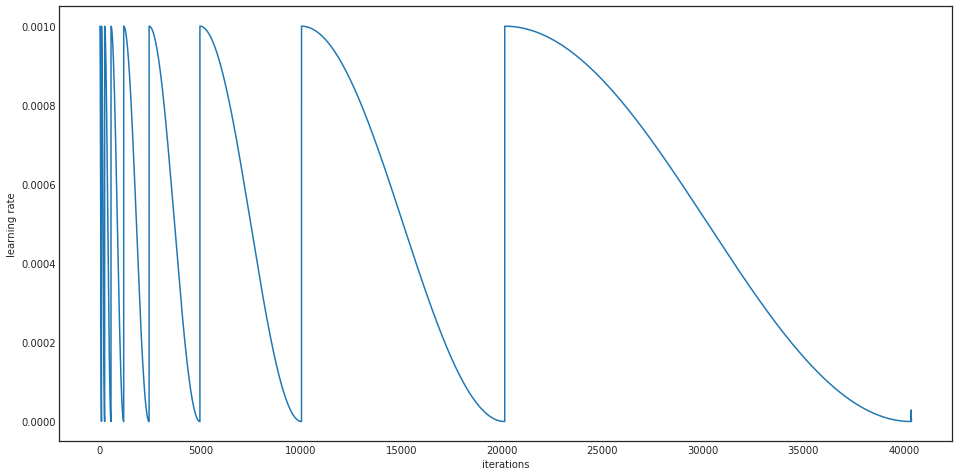

Fold took 599.623s

Running fold 4 / 10


/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213321). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106906). Check your callbacks.
  % delta_t_median)


1 New best found: 4.33928282577e-05
2 New best found: 3.836263174e-05
3 New best found: 3.79259667216e-05
4 New best found: 3.62990524826e-05
5 New best found: 3.55998774919e-05
6 New best found: 3.51048101244e-05
7 New best found: 3.49085471831e-05
9 New best found: 3.46667605708e-05
10 New best found: 3.44963164228e-05
11 New best found: 3.4445800082e-05
12 New best found: 3.39660926828e-05
13 New best found: 3.38485974998e-05
14 New best found: 3.3842615955e-05
19 New best found: 3.36884680263e-05
20 New best found: 3.35870007843e-05
21 New best found: 3.35677555413e-05
22 New best found: 3.34303446151e-05
23 New best found: 3.34001631937e-05
24 New best found: 3.32044009566e-05
25 New best found: 3.30300532076e-05
28 New best found: 3.29417641337e-05
31 New best found: 3.27794994543e-05
44 New best found: 3.26990583698e-05
49 New best found: 3.26274300052e-05
51 New best found: 3.24898693933e-05
52 New best found: 3.23207820725e-05
55 New best found: 3.2258320987e-05
58 New best fo

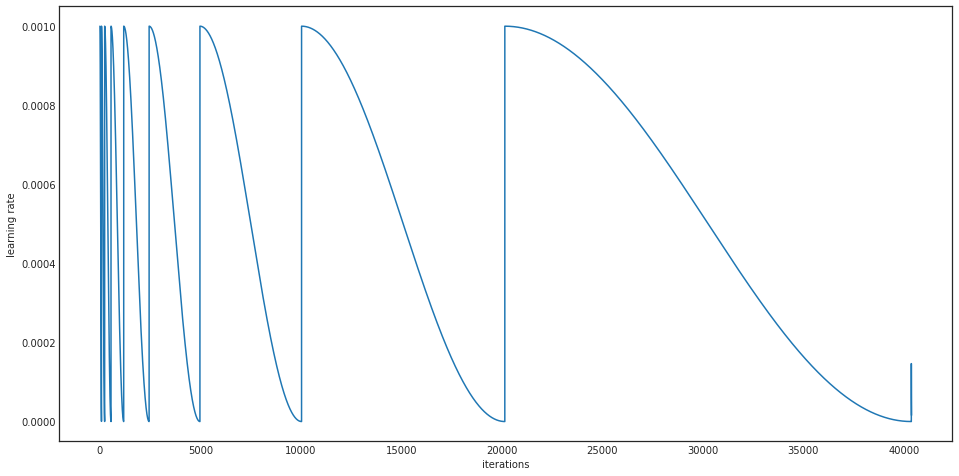

Fold took 581.106s

Running fold 5 / 10


/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.182128). Check your callbacks.
  % delta_t_median)


1 New best found: 4.33282556752e-05
2 New best found: 3.83304261537e-05
3 New best found: 3.74458027404e-05
4 New best found: 3.69353377462e-05
5 New best found: 3.50346834762e-05
6 New best found: 3.50166432593e-05
7 New best found: 3.48645627992e-05
8 New best found: 3.48465664069e-05
9 New best found: 3.48431332736e-05
10 New best found: 3.41993398201e-05
12 New best found: 3.40303669159e-05
13 New best found: 3.39639200998e-05
14 New best found: 3.39163313779e-05
15 New best found: 3.37865100488e-05
18 New best found: 3.37397532094e-05
20 New best found: 3.37230102722e-05
21 New best found: 3.35333755597e-05
22 New best found: 3.35232646069e-05
23 New best found: 3.3505869891e-05
24 New best found: 3.34446542045e-05
25 New best found: 3.33244468506e-05
26 New best found: 3.31750226587e-05
29 New best found: 3.29642865004e-05
30 New best found: 3.29519871805e-05
41 New best found: 3.28705633094e-05
45 New best found: 3.27574579532e-05
46 New best found: 3.27534971644e-05
47 New best

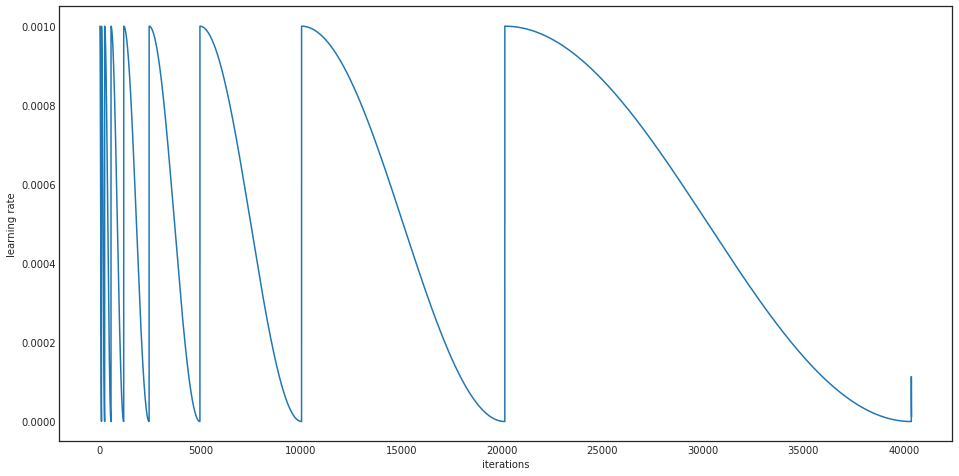

Fold took 595.326s

Running fold 6 / 10


/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.285259). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142949). Check your callbacks.
  % delta_t_median)


1 New best found: 4.49558062346e-05
2 New best found: 3.9674023451e-05
3 New best found: 3.84566416423e-05
4 New best found: 3.7457299401e-05
5 New best found: 3.70035600692e-05
6 New best found: 3.6158381837e-05
7 New best found: 3.60168624126e-05
8 New best found: 3.59661612957e-05
9 New best found: 3.5269180345e-05
10 New best found: 3.51713978211e-05
11 New best found: 3.50789258773e-05
12 New best found: 3.46586638177e-05
13 New best found: 3.463151803e-05
15 New best found: 3.45127080535e-05
21 New best found: 3.42153376336e-05
23 New best found: 3.42010735999e-05
24 New best found: 3.40313653788e-05
25 New best found: 3.39632024098e-05
27 New best found: 3.38317353268e-05
28 New best found: 3.37145784604e-05
31 New best found: 3.36935905163e-05
39 New best found: 3.36000057027e-05
42 New best found: 3.3440119777e-05
47 New best found: 3.33233784335e-05
48 New best found: 3.32128424213e-05
51 New best found: 3.30636224657e-05
55 New best found: 3.30379226614e-05
56 New best found

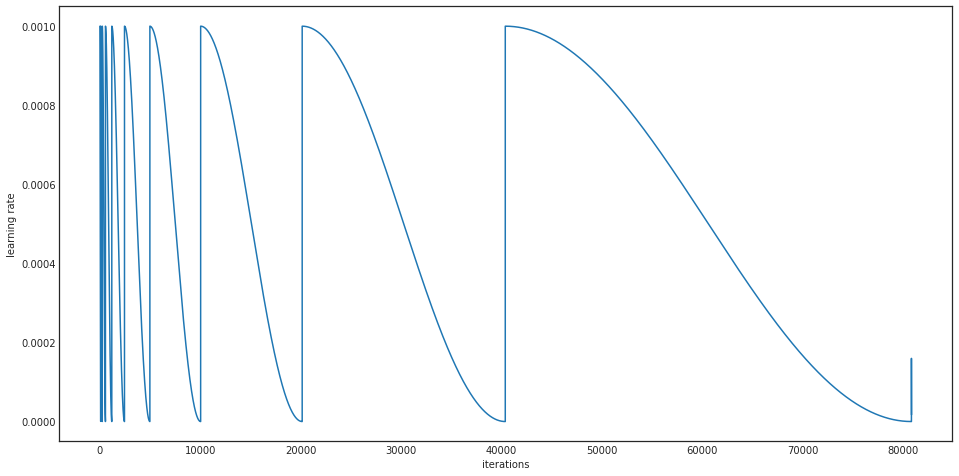

Fold took 1167.691s

Running fold 7 / 10


/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221670). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111090). Check your callbacks.
  % delta_t_median)


1 New best found: 4.31767881932e-05
2 New best found: 3.83700852252e-05
3 New best found: 3.73334888302e-05
4 New best found: 3.66029609212e-05
5 New best found: 3.56374953116e-05
6 New best found: 3.55464733511e-05
7 New best found: 3.54689876074e-05
8 New best found: 3.52347524052e-05
10 New best found: 3.50707781125e-05
11 New best found: 3.46328426828e-05
12 New best found: 3.43891186075e-05
13 New best found: 3.41314444709e-05
14 New best found: 3.41158112076e-05
15 New best found: 3.3904057403e-05
21 New best found: 3.38221378776e-05
23 New best found: 3.37775479109e-05
24 New best found: 3.33694873197e-05
26 New best found: 3.33228729013e-05
28 New best found: 3.32566534386e-05
30 New best found: 3.30607666057e-05
44 New best found: 3.28921632842e-05
46 New best found: 3.27461059116e-05
50 New best found: 3.27284536072e-05
51 New best found: 3.25918236588e-05
55 New best found: 3.25557048042e-05
59 New best found: 3.24296142023e-05
86 New best found: 3.22665775218e-05
103 New be

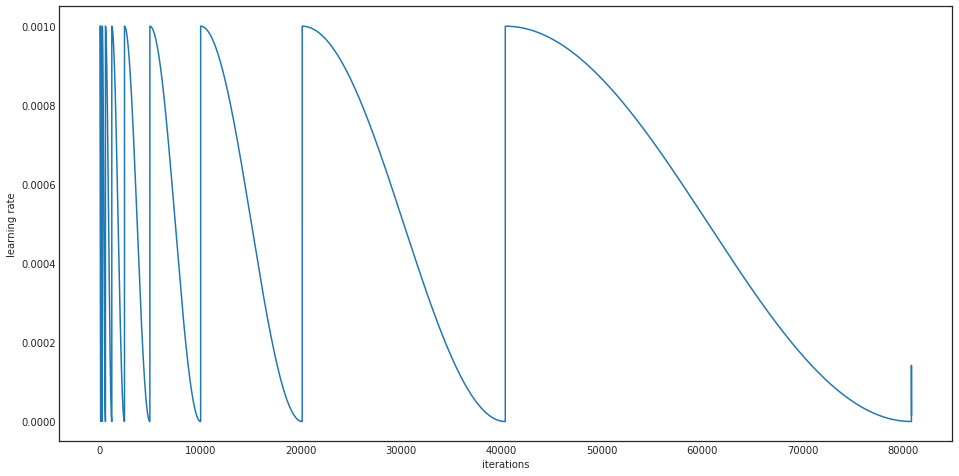

Fold took 1193.330s

Running fold 8 / 10


/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.330673). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.165621). Check your callbacks.
  % delta_t_median)


1 New best found: 4.2485606271e-05
2 New best found: 3.78478476853e-05
3 New best found: 3.72038762385e-05
5 New best found: 3.63485560184e-05
6 New best found: 3.56101824139e-05
7 New best found: 3.54888493141e-05
10 New best found: 3.48824271445e-05
11 New best found: 3.46642637705e-05
12 New best found: 3.4521759735e-05
13 New best found: 3.45134772491e-05
14 New best found: 3.41338477297e-05
22 New best found: 3.41208774263e-05
23 New best found: 3.40005608009e-05
24 New best found: 3.39652703298e-05
25 New best found: 3.38290281162e-05
26 New best found: 3.37054438205e-05
27 New best found: 3.34984690321e-05
28 New best found: 3.34484699865e-05
30 New best found: 3.34085349949e-05
31 New best found: 3.33718750405e-05
44 New best found: 3.32225376138e-05
45 New best found: 3.31713391456e-05
49 New best found: 3.30355474391e-05
52 New best found: 3.29859820735e-05
53 New best found: 3.29246283278e-05
56 New best found: 3.28396992433e-05
57 New best found: 3.28198976389e-05
60 New be

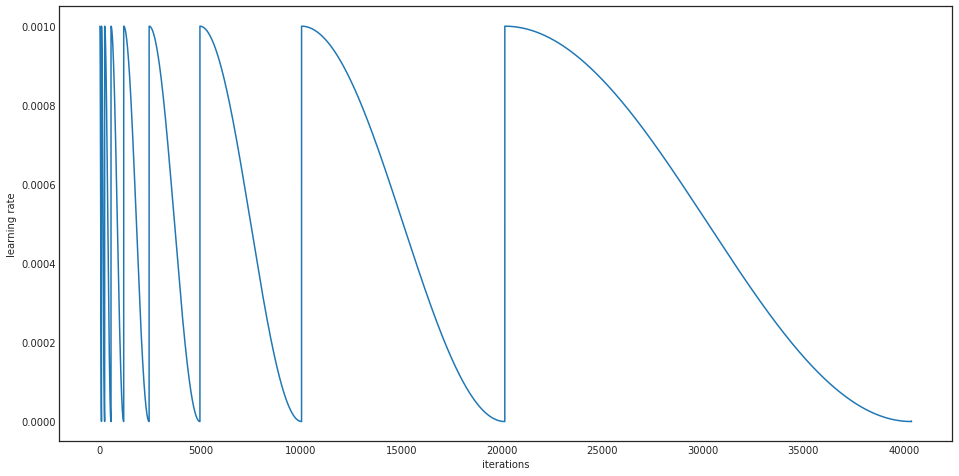

Fold took 596.736s

Running fold 9 / 10


/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.367690). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184272). Check your callbacks.
  % delta_t_median)


1 New best found: 4.38672753153e-05
2 New best found: 3.83633461306e-05
3 New best found: 3.7303825781e-05
4 New best found: 3.70872333542e-05
5 New best found: 3.61768171244e-05
6 New best found: 3.57646303331e-05
7 New best found: 3.56514904259e-05
9 New best found: 3.55582994815e-05
10 New best found: 3.52436070119e-05
12 New best found: 3.49010215586e-05
13 New best found: 3.47746629231e-05
15 New best found: 3.47188933957e-05
21 New best found: 3.44822597061e-05
22 New best found: 3.43040549967e-05
24 New best found: 3.41773946488e-05
25 New best found: 3.39624827621e-05
27 New best found: 3.3951485232e-05
28 New best found: 3.37989140596e-05
41 New best found: 3.37510960176e-05
42 New best found: 3.35462774248e-05
51 New best found: 3.33757937198e-05
57 New best found: 3.32352209669e-05
61 New best found: 3.32337501891e-05
82 New best found: 3.31905475579e-05
92 New best found: 3.31161113723e-05
95 New best found: 3.30918885732e-05
96 New best found: 3.30854945288e-05
100 New bes

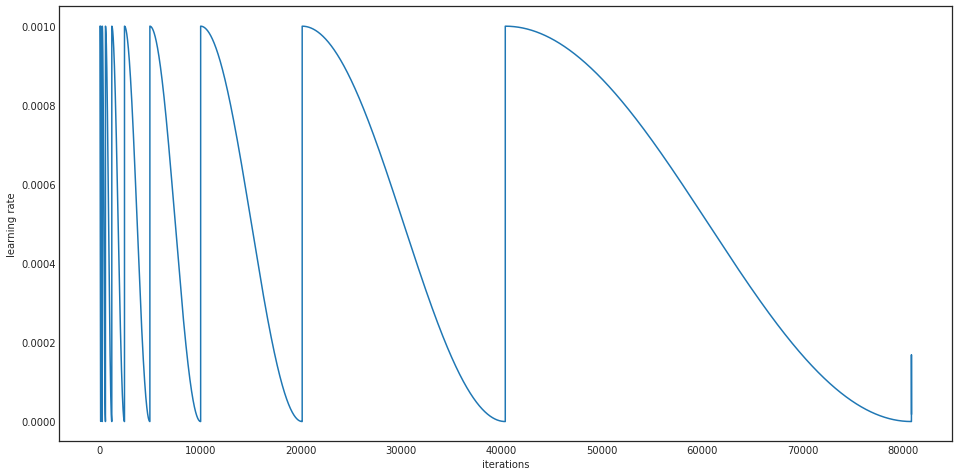

Fold took 1200.489s

Running fold 10 / 10


/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.360126). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180328). Check your callbacks.
  % delta_t_median)


1 New best found: 4.32678984167e-05
2 New best found: 3.85474878418e-05
3 New best found: 3.78812107448e-05
4 New best found: 3.67303017203e-05
5 New best found: 3.62622490718e-05
6 New best found: 3.55781818616e-05
8 New best found: 3.5498478901e-05
9 New best found: 3.54772472933e-05
10 New best found: 3.51974089153e-05
11 New best found: 3.50165083962e-05
12 New best found: 3.48160621612e-05
13 New best found: 3.45063893461e-05
14 New best found: 3.44734329729e-05
15 New best found: 3.42949634884e-05
22 New best found: 3.4190250547e-05
23 New best found: 3.38787434082e-05
25 New best found: 3.36436655228e-05
29 New best found: 3.35617594312e-05
37 New best found: 3.35218955915e-05
42 New best found: 3.32231885609e-05
43 New best found: 3.32158286039e-05
51 New best found: 3.31736261499e-05
52 New best found: 3.31648863376e-05
53 New best found: 3.30263790971e-05
57 New best found: 3.29917032375e-05
58 New best found: 3.29490108822e-05
60 New best found: 3.28096817485e-05
97 New best

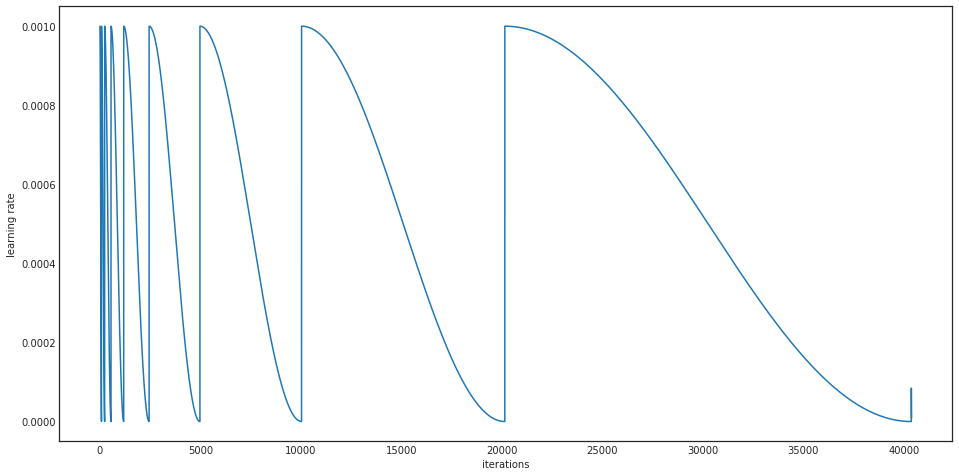

Fold took 617.859s


______________________________________
Training finished
Cross-validation took 8317.277s 


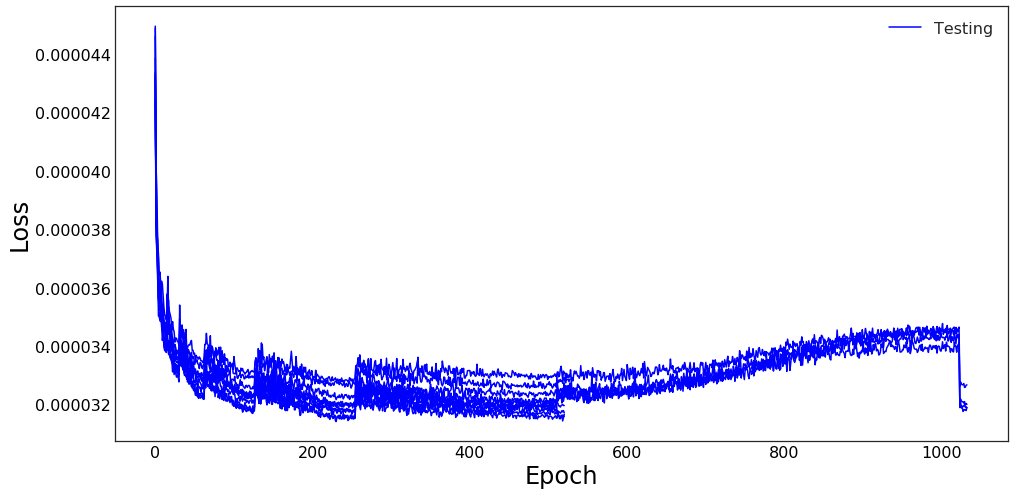

Mean wAUC = 0.0645 +- 0.0005
______________________________________



In [8]:
results, histories = batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams,
                                          patience=2, cosAnnealMult=2, reduxDecay=True, plotLR=True, trainOnWeights=True,
                                          maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [9]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [10]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

Choosing ensemble by loss
Model 0 is 1 with loss = 3.1422066746235e-05
Model 1 is 3 with loss = 3.149685650330097e-05
Model 2 is 4 with loss = 3.166090282129681e-05
Model 3 is 6 with loss = 3.1699188801393284e-05
Model 4 is 0 with loss = 3.17930640746e-05
Model 5 is 5 with loss = 3.184901853369678e-05
Model 6 is 7 with loss = 3.1888266228076995e-05
Model 7 is 9 with loss = 3.217127942135318e-05
Model 8 is 8 with loss = 3.250749405779412e-05
Model 9 is 2 with loss = 3.273310770361343e-05


In [13]:
np.mean([3.1422066746235e-05,
3.149685650330097e-05,
3.166090282129681e-05,
3.1699188801393284e-05,
3.17930640746e-05,
3.184901853369678e-05,
3.1888266228076995e-05,
3.217127942135318e-05,
3.250749405779412e-05,
3.273310770361343e-05])

3.1922124489136065e-05

## Response on development data

In [11]:
batchEnsemblePredict(ensemble, weights, trainData, ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00482806219625s per sample

Predicting batch 2 out of 10
Prediction took 0.0044941722402s per sample

Predicting batch 3 out of 10
Prediction took 0.00445801524793s per sample

Predicting batch 4 out of 10
Prediction took 0.00448299649954s per sample

Predicting batch 5 out of 10
Prediction took 0.00450091379881s per sample

Predicting batch 6 out of 10
Prediction took 0.00441610440016s per sample

Predicting batch 7 out of 10
Prediction took 0.00438808400631s per sample

Predicting batch 8 out of 10
Prediction took 0.00443175838163s per sample

Predicting batch 9 out of 10
Prediction took 0.00435127375799s per sample

Predicting batch 10 out of 10
Prediction took 0.00439368578737s per sample



In [12]:
print 'Training ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', trainData.source), getFeature('pred', trainData.source)),
                                                            roc_auc_score(getFeature('targets', trainData.source), getFeature('pred', trainData.source), sample_weight=getFeature('weights', trainData.source)))

Training ROC AUC: unweighted 0.905109157573, weighted 0.940621080777


## Response on val data

In [14]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00450003099442s per sample

Predicting batch 2 out of 10
Prediction took 0.00457048001289s per sample

Predicting batch 3 out of 10
Prediction took 0.00456164522171s per sample

Predicting batch 4 out of 10
Prediction took 0.00458582038879s per sample

Predicting batch 5 out of 10
Prediction took 0.0044699669838s per sample

Predicting batch 6 out of 10
Prediction took 0.00450709199905s per sample

Predicting batch 7 out of 10
Prediction took 0.00455824742317s per sample

Predicting batch 8 out of 10
Prediction took 0.00477653617859s per sample

Predicting batch 9 out of 10
Prediction took 0.00476932439804s per sample

Predicting batch 10 out of 10
Prediction took 0.00473991341591s per sample



In [15]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

Testing ROC AUC: unweighted 0.902205373245, weighted 0.935250615244


## Evaluation

### Import in dataframe

In [16]:
valframe = convertToDF(valData.source)

50000 candidates loaded


In [17]:
sigVal = (valframe.gen_target == 1)
bkgVal = (valframe.gen_target == 0)

### MVA distributions

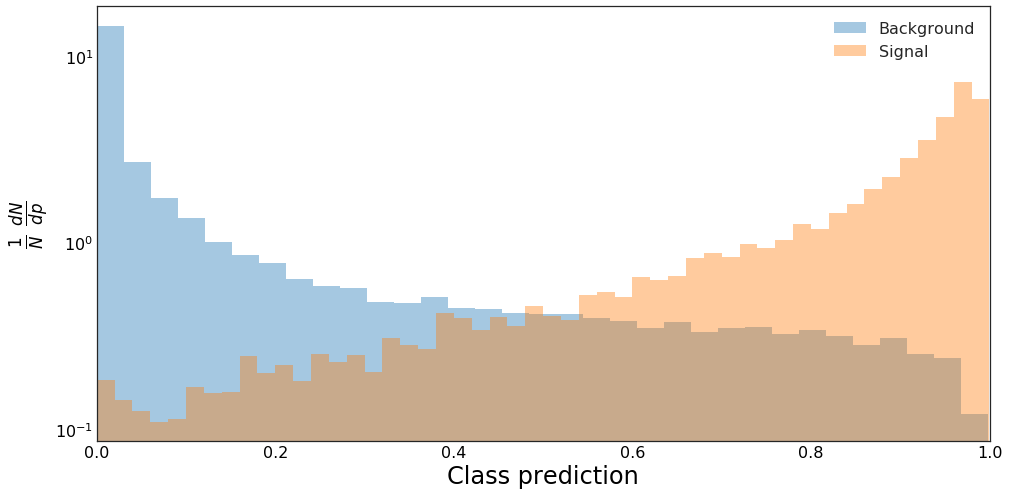

In [18]:
getClassPredPlot([valframe[bkgVal], valframe[sigVal]], weightName='gen_weight')

In [21]:
def amsScanQuick(inData, wFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = valframe['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * wFactor),max(0,b * wFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if valframe.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

In [23]:
amsMax, threshold = amsScanQuick(valframe)

3.898398783329272 0.9631335


In [ ]:
valframe['ams'] = amsScan(valframe)[0]

In [ ]:
bests = foldAMSScan(valframe, 10)

In [24]:
batchEnsemblePredict(ensemble, weights, RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+")), ensembleSize=10, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00435252578042s per sample

Predicting batch 2 out of 10
Prediction took 0.00438781341639s per sample

Predicting batch 3 out of 10
Prediction took 0.00435458450751s per sample

Predicting batch 4 out of 10
Prediction took 0.00434887052449s per sample

Predicting batch 5 out of 10
Prediction took 0.00434392925609s per sample

Predicting batch 6 out of 10
Prediction took 0.00432360451005s per sample

Predicting batch 7 out of 10
Prediction took 0.00444484067397s per sample

Predicting batch 8 out of 10
Prediction took 0.00438214021596s per sample

Predicting batch 9 out of 10
Prediction took 0.00435187958371s per sample

Predicting batch 10 out of 10
Prediction took 0.00436901909221s per sample



In [25]:
saveTest(0.9631335, 'Day_9_basic')

../Data/Day_9_basic_test.csv


In [26]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_9_basic_test.csv -m"Day_9 basic redux"

Successfully submitted to Higgs Boson Machine Learning Challenge